In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import clear_output

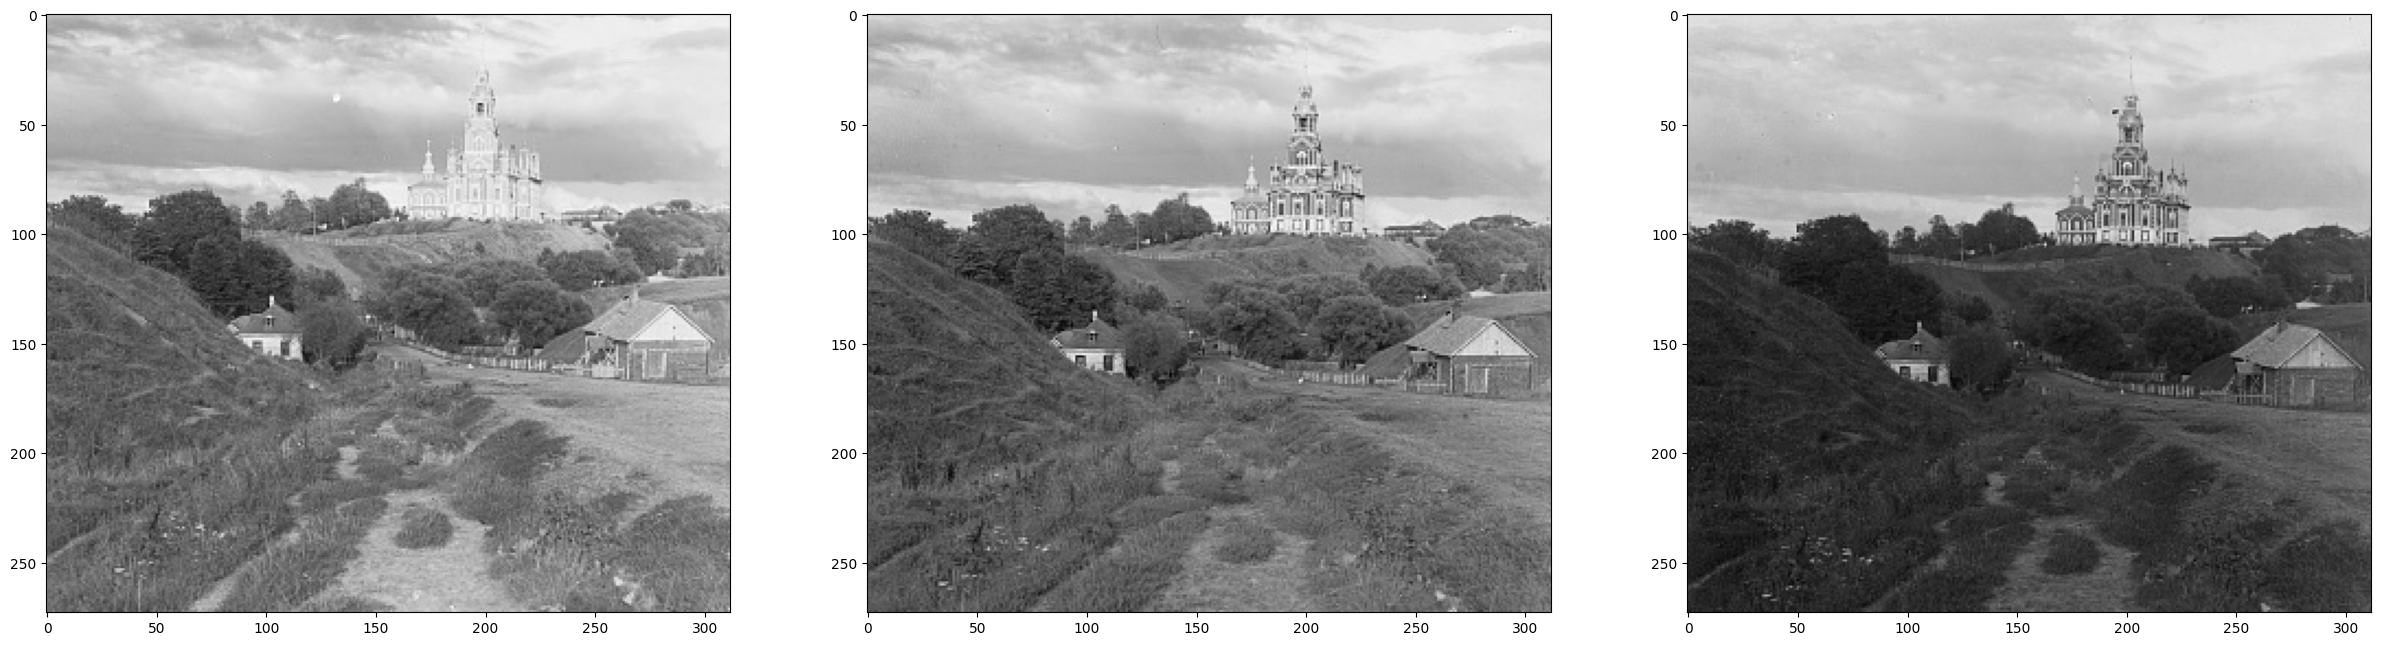

In [159]:
# name of the input file
imname = './data/cathedral.jpg'

# read in the image
im = cv2.imread(imname, cv2.IMREAD_GRAYSCALE)
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

v_border = int(r.shape[0]*0.1)
h_border = int(r.shape[1]*0.1)
# r_cropped = cv2.normalize(r[v_border:-v_border, h_border:-h_border], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# b_cropped = cv2.normalize(b[v_border:-v_border, h_border:-h_border], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# g_cropped = cv2.normalize(g[v_border:-v_border, h_border:-h_border], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
r_cropped = r[v_border:-v_border, h_border:-h_border]
b_cropped = b[v_border:-v_border, h_border:-h_border]
g_cropped = g[v_border:-v_border, h_border:-h_border]
rgb = np.array([r_cropped, g_cropped, b_cropped])

fig, axs = plt.subplots(1, 3, figsize=(30, 40))
axs[0].imshow(r_cropped, cmap='gray', vmin=0, vmax=255)
axs[1].imshow(g_cropped, cmap='gray', vmin=0, vmax=255)
axs[2].imshow(b_cropped, cmap='gray', vmin=0, vmax=255)

# rgb_adj = np.empty_like(rgb)
# kernel = np.floor(rgb[0].shape[0] * 0.01).astype(int)
# kernel = kernel + 1 if kernel % 2 == 0 else kernel
# print(kernel)

# for i in range(0, 3):
#     img_adj = rgb[i]
#     # white_point = np.percentile(img_adj, 50)
#     # print(white_point)
#     # img_adj = np.clip(img_adj + (255 - white_point), 0, 255).astype(np.uint8)
#     
#     img_adj = 255 - img_adj
#     img_adj = cv2.convertScaleAbs(img_adj, alpha = 1.1, beta = -20)
#     img_adj = 255 - img_adj
# 
#     rgb_adj[i] = img_adj
#     
# plt.imshow(rgb_adj[0], cmap='gray_r')

In [160]:
def ncc(matA, matB):
    sum = 0
    for y in range(0, matA.shape[0]):
        matAVec = matA[y, :]
        matBVec = matB[y, :]
        aNorm = np.linalg.norm(matAVec)
        bNorm = np.linalg.norm(matBVec)
        sum += np.dot(np.divide(matAVec, aNorm, where= aNorm!=0), np.divide(matBVec, bNorm, where= bNorm!=0))
        
    for x in range(0, matA.shape[1]):
        matAVec = matA[:, x]
        matBVec = matB[:, x]
        aNorm = np.linalg.norm(matAVec)
        bNorm = np.linalg.norm(matBVec)
        sum += np.dot(np.divide(matAVec, aNorm, where= aNorm!=0), np.divide(matBVec, bNorm, where= bNorm!=0))
    return sum

def shift_frame(x_shift, y_shift, matA):
    if x_shift < 0:
        if y_shift < 0:
            return matA[:y_shift, :x_shift]
        else:
            return matA[y_shift: ,:x_shift]
    else:
        if y_shift < 0:
            return matA[:y_shift ,x_shift:]
        else:
            return matA[y_shift: ,x_shift:]
            # if x < 0:
            #     if y < 0:
            #         layerFrameCropped = xShifted[:y, :x]
            #         baseFrameCropped = baseFrame[:y ,:x]
            #     else:
            #         layerFrameCropped = xShifted[y: ,:x]
            #         baseFrameCropped = baseFrame[y: ,:x]
            # else:
            #     if y < 0:
            #         layerFrameCropped = xShifted[:y ,x:]
            #         baseFrameCropped = baseFrame[:y ,x:]
            #     else:
            #         layerFrameCropped = xShifted[y: ,x:]
            #         baseFrameCropped = baseFrame[y: ,x:]

In [161]:
xRange = np.floor(r_cropped.shape[1] * 0.05).astype(int)
yRange = np.floor(r_cropped.shape[0] * 0.05).astype(int)
print("roll range x/y:", xRange, yRange)

baseFrame = r_cropped
shift = [[],[]]


for layer in range(1, 3):
    maxCorr = 0
    layerFrame = rgb[layer]
    if layer == 2:
        layerFrame = shift_frame(shift[0][-1][0], shift[0][-1][1], layerFrame)
    bestFrame = []
    
    for y in range(-yRange, yRange+1):
        yShifted = np.roll(layerFrame, y, axis=0)
        for x in range(-xRange, xRange+1):
            xShifted = np.roll(yShifted, x, axis=1)
            layerFrameCropped = shift_frame(x, y, xShifted)
            baseFrameCropped = shift_frame(x, y, baseFrame)
            corrScore = ncc(baseFrameCropped, layerFrameCropped)
            
            if corrScore > maxCorr:
                print(corrScore)
                maxCorr = corrScore
                bestX = x
                bestY = y
                # print(corrScore)
                bestFrame = [baseFrameCropped, layerFrameCropped]
                shift[layer-1].append([x,y])
                
    # baseFrame = cv2.normalize(np.sum(bestFrame, axis=0), 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    baseFrame = bestFrame[0]
    blank = np.zeros_like(bestFrame[0])
    
    
print(shift[0][-1], shift[1][-1])

roll range x/y: 15 13
541.4051028781091
542.6459525967751
543.7834650242276
544.9509175726714
546.1364315971271
547.220695446746
548.3044373509291
549.4208367713358
550.4254688792045
551.4510421068929
552.4385287609542
553.4250225098484
554.482463875328
555.3913916060326
556.4046641633369
557.2983564798556
557.3459354955489
558.416639113513
559.3011148630939
559.3313120590811
560.4954564564463
561.3694936458083
562.5868004812808
563.3496632216702
563.4215746597946
564.8167083625484
565.4956682510623
565.7484678099199
567.4899099485216
567.909431820911
568.6944666171701
572.5762726133295
521.879468349897
523.217967124622
524.5803395162467
525.9068118259459
527.2095117162321
528.5267634833481
529.8224040207381
531.3435055320881
532.7622994344101
534.3354934769035
535.7963484042796
537.1572352678511
538.927230625774
539.2976810101272
539.5631621335912
540.6701047666551
544.2958568790856
[-1, -7] [-3, -12]


(266, 311) (266, 311) (266, 311)
(254, 308) (254, 308) (254, 308)


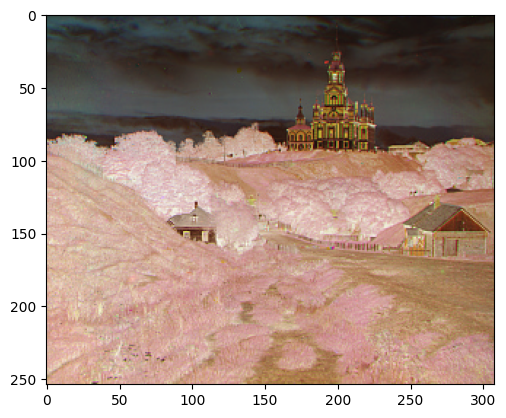

In [162]:
finalShift = np.array([shift[0][-1], shift[1][-1]])

r = shift_frame(finalShift[0, 0], finalShift[0, 1], rgb[0])
g = shift_frame(finalShift[0, 0], finalShift[0, 1], np.roll(rgb[1], (finalShift[0, 0], finalShift[0, 1]), axis=(1, 0)))
b = shift_frame(finalShift[0, 0], finalShift[0, 1], rgb[2])
print(r.shape, g.shape, b.shape)


r = shift_frame(finalShift[1, 0], finalShift[1, 1], r)
g = shift_frame(finalShift[1, 0], finalShift[1, 1], g)
b = shift_frame(finalShift[1, 0], finalShift[1, 1], np.roll(b, (finalShift[1, 0], finalShift[1, 1]), axis=(1, 0)))
print(r.shape, g.shape, b.shape)

# r = cv2.normalize(shift_frame(finalShift[1, 0], finalShift[1, 1], r), None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# g = cv2.normalize(shift_frame(finalShift[1, 0], finalShift[1, 1], g), None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# b = cv2.normalize(shift_frame(finalShift[1, 0], finalShift[1, 1], np.roll(b, (finalShift[1, 0], finalShift[1, 1]), axis=(1, 0))), None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# print(r.shape, g.shape, b.shape)

colorized = 255 - np.stack((b,g,r), axis=2)
cv2.normalize(colorized, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
plt.imshow(colorized)